In [1]:
import os
import matplotlib.pyplot as plt
from openghg.client import get_obs_surface
from openghg.store import Emissions, Footprints, ObsSurface
from openghg.analyse import footprints_data_merge
from openghg.retrieve import get_footprint

# object_store = "/work/<username>/object_store"

import tempfile
tmp_dir = tempfile.TemporaryDirectory()
object_store = tmp_dir.name # "/tmp/openghg_store"

os.environ["OPENGHG_PATH"] = object_store

/user/home/rt17603/work/environments/openghg_env/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
site="tac" 
network="DECC"
height="100m"
domain="EUROPE"
species="ch4"

In [3]:
obs_file = "../data/DECC/tac.picarro.1minute.100m.201208.dat"

ObsSurface.read_file(filepath=obs_file, data_type="CRDS", site=site, network=network, inlet=height)

Processing: tac.picarro.1minute.100m.201208.dat: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


defaultdict(dict,
            {'processed': {'tac.picarro.1minute.100m.201208.dat': {'ch4': '9237c2a4-fd2a-4439-a352-4485f58f19a1',
               'co2': '56b1fc3e-9914-41bd-b272-8d2e3a26a88a'}}})

/user/home/rt17603/work/environments/openghg_env/lib/python3.8/site-packages/xarray/core/indexes.py:97: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  indexer = index.slice_indexer(


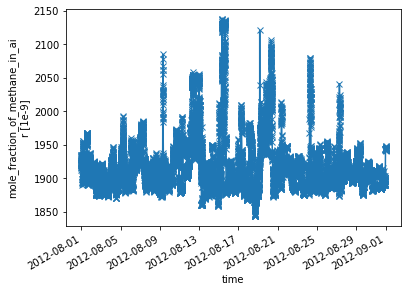

In [4]:
site="tac"  # Have to include otherwise sees site as an internal package
start_date = "2012-08-01"
end_date = "2012-09-01"

obs = get_obs_surface(site=site, species=species, start_date=start_date,
                        end_date=end_date, inlet=height, network=network)

mf = obs.data["mf"]
mf.plot(marker="x")

In [5]:
fp_file_path = "../data/footprints/TAC-100magl_EUROPE_201208.nc"

site="tac" 
height="100m"
domain="EUROPE"
model="NAME"

Footprints.read_file(filepath=fp_file_path, site=site, height=height, domain=domain, model=model)

{'tac_europe_NAME_100m': '79a6c207-7110-4e34-a016-1366e01d87a9'}

In [6]:
flux_file_path = "../data/emissions/ch4-anthro_EUROPE_2012.nc"

species = "ch4"
domain = "EUROPE"
source = "anthro"
date = "2012"

Emissions.read_file(filepath=flux_file_path, species=species, source=source, domain=domain, date=date)

{'ch4_anthro_europe_2012': 'c97588bc-f57a-42cd-b1cd-a6d1d460930d'}

In [7]:
# Use get_obs_surface to extract obs results from the object store
obs_surface = get_obs_surface(
    site=site, inlet=height, start_date=start_date, end_date=end_date, species=species)
# obs_results = obs_surface.data
print(type(obs_surface))

<class 'openghg.dataobjects._obsdata.ObsData'>


/user/home/rt17603/work/environments/openghg_env/lib/python3.8/site-packages/xarray/core/indexes.py:97: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  indexer = index.slice_indexer(


In [8]:
# Extract footprint results from the object store

footprint = get_footprint(site=site, domain=domain, height=height,
               start_date=start_date, end_date=end_date)

In [9]:
from openghg.analyse import ModelScenario

model = ModelScenario(obs=obs_surface, footprint=footprint)

In [10]:
obs_surface.data.time

<xarray.DataArray 'time' (time: 20509)>
array(['2012-08-01T00:00:30.000000000', '2012-08-01T00:01:30.000000000',
       '2012-08-01T00:02:30.000000000', ..., '2012-08-31T23:45:30.000000000',
       '2012-08-31T23:46:30.000000000', '2012-08-31T23:47:30.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2012-08-01T00:00:30 ... 2012-08-31T23:47:30
Attributes:
    label:                    left
    standard_name:            time
    comment:                  Time stamp corresponds to beginning of sampling...
    sampling_period_seconds:  60

In [11]:
obs_surface.data.time.diff(dim="time")

<xarray.DataArray 'time' (time: 20508)>
array([60000000000, 60000000000, 60000000000, ..., 60000000000,
       60000000000, 60000000000], dtype='timedelta64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2012-08-01T00:01:30 ... 2012-08-31T23:47:30

In [12]:
freq = footprint.data.time.diff(dim="time").mean()
print(freq)

<xarray.DataArray 'time' ()>
array(7200000000000, dtype='timedelta64[ns]')


In [13]:
model.combine_obs_footprint(resample_to="coarsest")

<xarray.Dataset>
Dimensions:                    (time: 372, lon: 391, lat: 293, lev: 1, height: 20)
Coordinates:
  * time                       (time) datetime64[ns] 2012-08-01T00:00:30 ... ...
  * lon                        (lon) float32 -97.9 -97.55 -97.2 ... 39.03 39.38
  * lat                        (lat) float32 10.73 10.96 11.2 ... 78.82 79.06
  * lev                        (lev) object 'From     0 -    40m agl'
  * height                     (height) float32 500.0 1.5e+03 ... 1.95e+04
Data variables: (12/15)
    mf                         (time) float64 1.922e+03 1.934e+03 ... 1.921e+03
    mf_variability             (time) float64 3.155 2.061 3.597 ... 0.237 0.5685
    mf_number_of_observations  (time) float64 19.56 19.86 19.36 ... 19.68 19.43
    fp                         (lat, lon, time) float32 nan 0.0 ... 7.629e-06
    temperature                (time) float32 nan 14.35 14.01 ... 13.07 13.31
    pressure                   (time) float32 nan 994.3 ... 1.01e+03 1.009e+03
    ...                         ...
    release_lon                (time) float32 nan 1.139 1.139 ... 1.139 1.139
    release_lat                (time) float32 nan 52.52 52.52 ... 52.52 52.52
    particle_locations_n       (height, lon, time) float32 nan 3.248e-05 ... 0.0
    particle_locations_e       (height, lat, time) float32 nan 0.0 ... 0.0 0.0
    particle_locations_s       (height, lon, time) float32 nan 0.0 ... 0.0 0.0
    particle_locations_w       (height, lat, time) float32 nan 0.0 ... 0.0 0.0
Attributes:
    resample_to:  coarsest

In [14]:
from openghg.retrieve import get_flux

species = "ch4"
domain = "EUROPE"
source = "anthro"
start_date = "2012-01-01"
end_date = "2013-01-01"

# Extract flux results from object store
# TODO: Decide if this should return a Emissions type object (as get_obs_surface does) or an xarray Dataset directly (as this does at the moment)
flux_results = get_flux(species=species,
                        domain=domain,
                        source=source,
                        start_date=start_date,
                        end_date=end_date)

In [15]:
flux_results

FluxData(data=<xarray.Dataset>
Dimensions:  (lat: 293, lon: 391, time: 1)
Coordinates:
  * lat      (lat) float32 10.73 10.96 11.2 11.43 ... 78.36 78.59 78.82 79.06
  * lon      (lon) float32 -97.9 -97.55 -97.2 -96.84 ... 38.32 38.68 39.03 39.38
  * time     (time) datetime64[ns] 2012-01-01
Data variables:
    flux     (lat, lon, time) float32 4.122e-13 1.302e-13 1.386e-12 ... 0.0 0.0
Attributes: (12/21)
    title:                        ch4 emissions from EDGARv5.0 database.
    author:                       OpenGHG Cloud
    date_created:                 2021-03-31 16:29:46.917793
    number_of_prior_files_used:   1
    prior_file_1:                 EDGARv5.0
    prior_file_1_version:         v5.0
    ...                           ...
    end_date:                     2012-01-01 00:00:00+00:00
    max_longitude:                39.38
    min_longitude:                -97.89999
    max_latitude:                 79.057
    min_latitude:                 10.729
    time_resolution:       

In [16]:
# Add flux results
model.add_flux(flux=flux_results)

In [17]:
# TODO: Want to calculate the modelled mole fraction using `model` when this has been written into the code

model.calc_modelled_obs()

Caching calculated data


<xarray.DataArray 'mf_mod' (time: 372)>
array([0.00000000e+00, 1.54310044e-07, 1.31978325e-07, 7.30628287e-08,
       5.25465005e-08, 5.86561271e-08, 6.39344861e-08, 6.22678655e-08,
       4.89236314e-08, 7.53911849e-08, 1.11273962e-07, 9.97699345e-08,
       7.46737214e-08, 8.81430537e-08, 1.15799381e-07, 1.23181579e-07,
       1.33098695e-07, 9.44010878e-08, 3.83624865e-08, 2.81043349e-08,
       3.10859711e-08, 3.93195130e-08, 5.94076788e-08, 8.41500949e-08,
       9.43655891e-08, 7.74948532e-08, 7.54217311e-08, 6.14004136e-08,
       5.27383470e-08, 5.28724762e-08, 4.47301360e-08, 6.73052654e-08,
       5.76563863e-08, 3.76709188e-08, 6.59740849e-08, 9.89157556e-08,
       1.12677903e-07, 1.21354390e-07, 1.21653400e-07, 7.75951534e-08,
       7.21925844e-08, 8.37610656e-08, 6.69128681e-08, 5.86544360e-08,
       5.82769495e-08, 5.98070429e-08, 8.34151095e-08, 1.18715214e-07,
       1.45076768e-07, 1.56817762e-07, 1.58812796e-07, 1.40126218e-07,
       1.20479356e-07, 1.14129037e-07, 1.17007353e-07, 8.38486685e-08,
       7.13715593e-08, 8.05775997e-08, 9.82184361e-08, 1.60872190e-07,
       1.94842272e-07, 2.04866382e-07, 2.28244744e-07, 2.14833292e-07,
       2.29511812e-07, 2.32336077e-07, 2.28913947e-07, 2.01781958e-07,
       1.81206715e-07, 1.82869812e-07, 2.04869536e-07, 2.45090320e-07,
       2.74953607e-07, 2.73266295e-07, 2.71409334e-07, 1.53855964e-07,
       9.03104578e-08, 1.00741751e-07, 1.06866096e-07, 8.69460308e-08,
...
       1.13397427e-07, 1.77793964e-07, 2.44865902e-07, 2.88671089e-07,
       3.18485263e-07, 1.34000175e-07, 1.30212158e-07, 9.70383880e-08,
       8.67518324e-08, 6.76227430e-08, 4.25872777e-08, 3.38811397e-08,
       3.90024297e-08, 3.80831118e-08, 3.08538581e-08, 6.14462294e-08,
       1.48136280e-07, 1.72629925e-07, 1.64870727e-07, 1.40497860e-07,
       6.23501890e-08, 3.77037210e-08, 4.99714972e-08, 6.77184318e-08,
       7.25856353e-08, 8.94025050e-08, 9.41682501e-08, 1.01575246e-07,
       1.10544541e-07, 9.81335617e-08, 9.93139082e-08, 7.59025127e-08,
       6.02059913e-08, 4.73522732e-08, 4.48181936e-08, 4.76716764e-08,
       4.49713973e-08, 4.68226133e-08, 6.79949181e-08, 8.88970959e-08,
       1.06341837e-07, 1.33225427e-07, 1.17800937e-07, 5.63719098e-08,
       5.67702472e-08, 6.15311748e-08, 6.30112282e-08, 5.45894210e-08,
       4.68812225e-08, 4.83979150e-08, 6.38337951e-08, 8.44519121e-08,
       1.00654930e-07, 1.04279081e-07, 9.99825431e-08, 7.87597614e-08,
       7.58306413e-08, 1.21938783e-07, 1.78236178e-07, 1.01447256e-07,
       1.14764633e-08, 1.33199727e-08, 1.44947050e-08, 1.55996709e-08,
       1.73443482e-08, 2.07801012e-08, 2.51978900e-08, 1.41029801e-08,
       1.56377506e-08, 2.14150706e-08, 2.58083119e-08, 2.54035122e-08,
       3.48842377e-08, 4.67875978e-08, 4.59588243e-08, 6.69008529e-08],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2012-08-01T00:00:30 ... 2012-08-31T22:00:30
Attributes:
    resample_to:  coarsest

In [18]:
obs_modelled = model.calc_modelled_obs(recalculate=True)

Caching calculated data


In [19]:
model.calc_modelled_obs(resample_to="footprint")

Caching calculated data


<xarray.DataArray 'mf_mod' (time: 372)>
array([0.00000000e+00, 1.54310044e-07, 1.31978325e-07, 7.30628287e-08,
       5.25465005e-08, 5.86561271e-08, 6.39344861e-08, 6.22678655e-08,
       4.89236314e-08, 7.53911849e-08, 1.11273962e-07, 9.97699345e-08,
       7.46737214e-08, 8.81430537e-08, 1.15799381e-07, 1.23181579e-07,
       1.33098695e-07, 9.44010878e-08, 3.83624865e-08, 2.81043349e-08,
       3.10859711e-08, 3.93195130e-08, 5.94076788e-08, 8.41500949e-08,
       9.43655891e-08, 7.74948532e-08, 7.54217311e-08, 6.14004136e-08,
       5.27383470e-08, 5.28724762e-08, 4.47301360e-08, 6.73052654e-08,
       5.76563863e-08, 3.76709188e-08, 6.59740849e-08, 9.89157556e-08,
       1.12677903e-07, 1.21354390e-07, 1.21653400e-07, 7.75951534e-08,
       7.21925844e-08, 8.37610656e-08, 6.69128681e-08, 5.86544360e-08,
       5.82769495e-08, 5.98070429e-08, 8.34151095e-08, 1.18715214e-07,
       1.45076768e-07, 1.56817762e-07, 1.58812796e-07, 1.40126218e-07,
       1.20479356e-07, 1.14129037e-07, 1.17007353e-07, 8.38486685e-08,
       7.13715593e-08, 8.05775997e-08, 9.82184361e-08, 1.60872190e-07,
       1.94842272e-07, 2.04866382e-07, 2.28244744e-07, 2.14833292e-07,
       2.29511812e-07, 2.32336077e-07, 2.28913947e-07, 2.01781958e-07,
       1.81206715e-07, 1.82869812e-07, 2.04869536e-07, 2.45090320e-07,
       2.74953607e-07, 2.73266295e-07, 2.71409334e-07, 1.53855964e-07,
       9.03104578e-08, 1.00741751e-07, 1.06866096e-07, 8.69460308e-08,
...
       1.13397427e-07, 1.77793964e-07, 2.44865902e-07, 2.88671089e-07,
       3.18485263e-07, 1.34000175e-07, 1.30212158e-07, 9.70383880e-08,
       8.67518324e-08, 6.76227430e-08, 4.25872777e-08, 3.38811397e-08,
       3.90024297e-08, 3.80831118e-08, 3.08538581e-08, 6.14462294e-08,
       1.48136280e-07, 1.72629925e-07, 1.64870727e-07, 1.40497860e-07,
       6.23501890e-08, 3.77037210e-08, 4.99714972e-08, 6.77184318e-08,
       7.25856353e-08, 8.94025050e-08, 9.41682501e-08, 1.01575246e-07,
       1.10544541e-07, 9.81335617e-08, 9.93139082e-08, 7.59025127e-08,
       6.02059913e-08, 4.73522732e-08, 4.48181936e-08, 4.76716764e-08,
       4.49713973e-08, 4.68226133e-08, 6.79949181e-08, 8.88970959e-08,
       1.06341837e-07, 1.33225427e-07, 1.17800937e-07, 5.63719098e-08,
       5.67702472e-08, 6.15311748e-08, 6.30112282e-08, 5.45894210e-08,
       4.68812225e-08, 4.83979150e-08, 6.38337951e-08, 8.44519121e-08,
       1.00654930e-07, 1.04279081e-07, 9.99825431e-08, 7.87597614e-08,
       7.58306413e-08, 1.21938783e-07, 1.78236178e-07, 1.01447256e-07,
       1.14764633e-08, 1.33199727e-08, 1.44947050e-08, 1.55996709e-08,
       1.73443482e-08, 2.07801012e-08, 2.51978900e-08, 1.41029801e-08,
       1.56377506e-08, 2.14150706e-08, 2.58083119e-08, 2.54035122e-08,
       3.48842377e-08, 4.67875978e-08, 4.59588243e-08, 6.69008529e-08],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2012-08-01T00:00:30 ... 2012-08-31T22:00:30
Attributes:
    resample_to:  footprint

In [20]:
model.modelled_obs

<xarray.DataArray 'mf_mod' (time: 372)>
array([0.00000000e+00, 1.54310044e-07, 1.31978325e-07, 7.30628287e-08,
       5.25465005e-08, 5.86561271e-08, 6.39344861e-08, 6.22678655e-08,
       4.89236314e-08, 7.53911849e-08, 1.11273962e-07, 9.97699345e-08,
       7.46737214e-08, 8.81430537e-08, 1.15799381e-07, 1.23181579e-07,
       1.33098695e-07, 9.44010878e-08, 3.83624865e-08, 2.81043349e-08,
       3.10859711e-08, 3.93195130e-08, 5.94076788e-08, 8.41500949e-08,
       9.43655891e-08, 7.74948532e-08, 7.54217311e-08, 6.14004136e-08,
       5.27383470e-08, 5.28724762e-08, 4.47301360e-08, 6.73052654e-08,
       5.76563863e-08, 3.76709188e-08, 6.59740849e-08, 9.89157556e-08,
       1.12677903e-07, 1.21354390e-07, 1.21653400e-07, 7.75951534e-08,
       7.21925844e-08, 8.37610656e-08, 6.69128681e-08, 5.86544360e-08,
       5.82769495e-08, 5.98070429e-08, 8.34151095e-08, 1.18715214e-07,
       1.45076768e-07, 1.56817762e-07, 1.58812796e-07, 1.40126218e-07,
       1.20479356e-07, 1.14129037e-07, 1.17007353e-07, 8.38486685e-08,
       7.13715593e-08, 8.05775997e-08, 9.82184361e-08, 1.60872190e-07,
       1.94842272e-07, 2.04866382e-07, 2.28244744e-07, 2.14833292e-07,
       2.29511812e-07, 2.32336077e-07, 2.28913947e-07, 2.01781958e-07,
       1.81206715e-07, 1.82869812e-07, 2.04869536e-07, 2.45090320e-07,
       2.74953607e-07, 2.73266295e-07, 2.71409334e-07, 1.53855964e-07,
       9.03104578e-08, 1.00741751e-07, 1.06866096e-07, 8.69460308e-08,
...
       1.13397427e-07, 1.77793964e-07, 2.44865902e-07, 2.88671089e-07,
       3.18485263e-07, 1.34000175e-07, 1.30212158e-07, 9.70383880e-08,
       8.67518324e-08, 6.76227430e-08, 4.25872777e-08, 3.38811397e-08,
       3.90024297e-08, 3.80831118e-08, 3.08538581e-08, 6.14462294e-08,
       1.48136280e-07, 1.72629925e-07, 1.64870727e-07, 1.40497860e-07,
       6.23501890e-08, 3.77037210e-08, 4.99714972e-08, 6.77184318e-08,
       7.25856353e-08, 8.94025050e-08, 9.41682501e-08, 1.01575246e-07,
       1.10544541e-07, 9.81335617e-08, 9.93139082e-08, 7.59025127e-08,
       6.02059913e-08, 4.73522732e-08, 4.48181936e-08, 4.76716764e-08,
       4.49713973e-08, 4.68226133e-08, 6.79949181e-08, 8.88970959e-08,
       1.06341837e-07, 1.33225427e-07, 1.17800937e-07, 5.63719098e-08,
       5.67702472e-08, 6.15311748e-08, 6.30112282e-08, 5.45894210e-08,
       4.68812225e-08, 4.83979150e-08, 6.38337951e-08, 8.44519121e-08,
       1.00654930e-07, 1.04279081e-07, 9.99825431e-08, 7.87597614e-08,
       7.58306413e-08, 1.21938783e-07, 1.78236178e-07, 1.01447256e-07,
       1.14764633e-08, 1.33199727e-08, 1.44947050e-08, 1.55996709e-08,
       1.73443482e-08, 2.07801012e-08, 2.51978900e-08, 1.41029801e-08,
       1.56377506e-08, 2.14150706e-08, 2.58083119e-08, 2.54035122e-08,
       3.48842377e-08, 4.67875978e-08, 4.59588243e-08, 6.69008529e-08],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2012-08-01T00:00:30 ... 2012-08-31T22:00:30
Attributes:
    resample_to:  footprint

In [21]:
model.scenario

<xarray.Dataset>
Dimensions:                    (time: 372, lon: 391, lat: 293, lev: 1, height: 20)
Coordinates:
  * time                       (time) datetime64[ns] 2012-08-01T00:00:30 ... ...
  * lon                        (lon) float32 -97.9 -97.55 -97.2 ... 39.03 39.38
  * lat                        (lat) float32 10.73 10.96 11.2 ... 78.82 79.06
  * lev                        (lev) object 'From     0 -    40m agl'
  * height                     (height) float32 500.0 1.5e+03 ... 1.95e+04
Data variables: (12/15)
    mf                         (time) float64 1.922e+03 1.934e+03 ... 1.921e+03
    mf_variability             (time) float64 3.155 2.061 3.597 ... 0.237 0.5685
    mf_number_of_observations  (time) float64 19.56 19.86 19.36 ... 19.68 19.43
    fp                         (lat, lon, time) float32 nan 0.0 ... 7.629e-06
    temperature                (time) float32 nan 14.35 14.01 ... 13.07 13.31
    pressure                   (time) float32 nan 994.3 ... 1.01e+03 1.009e+03
    ...                         ...
    release_lon                (time) float32 nan 1.139 1.139 ... 1.139 1.139
    release_lat                (time) float32 nan 52.52 52.52 ... 52.52 52.52
    particle_locations_n       (height, lon, time) float32 nan 3.248e-05 ... 0.0
    particle_locations_e       (height, lat, time) float32 nan 0.0 ... 0.0 0.0
    particle_locations_s       (height, lon, time) float32 nan 0.0 ... 0.0 0.0
    particle_locations_w       (height, lat, time) float32 nan 0.0 ... 0.0 0.0
Attributes:
    resample_to:  footprint

In [22]:
# model.calc_modelled_obs(resample_to="obs")

In [23]:
model.calc_modelled_obs(resample_to="1D")

Caching calculated data


<xarray.DataArray 'mf_mod' (time: 32)>
array([0.00000000e+00, 8.38968290e-08, 7.74476945e-08, 6.70681501e-08,
       8.89495837e-08, 1.24753043e-07, 2.19121958e-07, 1.26083378e-07,
       1.06624341e-07, 1.00646652e-07, 1.04505645e-07, 6.13159798e-08,
       1.01654827e-07, 9.29224981e-08, 7.30279623e-08, 1.32126061e-07,
       5.88418629e-08, 4.28976996e-08, 6.50935448e-08, 1.16474531e-07,
       1.74374733e-07, 1.37856773e-07, 7.88510022e-08, 8.53431033e-08,
       9.00777906e-08, 1.51027379e-07, 7.58002940e-08, 9.70013971e-08,
       6.90332627e-08, 7.39582191e-08, 6.93904738e-08, 3.11702735e-08],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2012-07-31T00:12:00 ... 2012-08-31T00:12:00
Attributes:
    resample_to:  1D

In [24]:
combined_data = model.footprints_data_merge(resample_to="coarsest") #, recalculate=True)

Caching calculated data


In [25]:
combined_data.mf_mod

<xarray.DataArray 'mf_mod' (time: 372)>
array([0.00000000e+00, 1.54310044e-07, 1.31978325e-07, 7.30628287e-08,
       5.25465005e-08, 5.86561271e-08, 6.39344861e-08, 6.22678655e-08,
       4.89236314e-08, 7.53911849e-08, 1.11273962e-07, 9.97699345e-08,
       7.46737214e-08, 8.81430537e-08, 1.15799381e-07, 1.23181579e-07,
       1.33098695e-07, 9.44010878e-08, 3.83624865e-08, 2.81043349e-08,
       3.10859711e-08, 3.93195130e-08, 5.94076788e-08, 8.41500949e-08,
       9.43655891e-08, 7.74948532e-08, 7.54217311e-08, 6.14004136e-08,
       5.27383470e-08, 5.28724762e-08, 4.47301360e-08, 6.73052654e-08,
       5.76563863e-08, 3.76709188e-08, 6.59740849e-08, 9.89157556e-08,
       1.12677903e-07, 1.21354390e-07, 1.21653400e-07, 7.75951534e-08,
       7.21925844e-08, 8.37610656e-08, 6.69128681e-08, 5.86544360e-08,
       5.82769495e-08, 5.98070429e-08, 8.34151095e-08, 1.18715214e-07,
       1.45076768e-07, 1.56817762e-07, 1.58812796e-07, 1.40126218e-07,
       1.20479356e-07, 1.14129037e-07, 1.17007353e-07, 8.38486685e-08,
       7.13715593e-08, 8.05775997e-08, 9.82184361e-08, 1.60872190e-07,
       1.94842272e-07, 2.04866382e-07, 2.28244744e-07, 2.14833292e-07,
       2.29511812e-07, 2.32336077e-07, 2.28913947e-07, 2.01781958e-07,
       1.81206715e-07, 1.82869812e-07, 2.04869536e-07, 2.45090320e-07,
       2.74953607e-07, 2.73266295e-07, 2.71409334e-07, 1.53855964e-07,
       9.03104578e-08, 1.00741751e-07, 1.06866096e-07, 8.69460308e-08,
...
       1.13397427e-07, 1.77793964e-07, 2.44865902e-07, 2.88671089e-07,
       3.18485263e-07, 1.34000175e-07, 1.30212158e-07, 9.70383880e-08,
       8.67518324e-08, 6.76227430e-08, 4.25872777e-08, 3.38811397e-08,
       3.90024297e-08, 3.80831118e-08, 3.08538581e-08, 6.14462294e-08,
       1.48136280e-07, 1.72629925e-07, 1.64870727e-07, 1.40497860e-07,
       6.23501890e-08, 3.77037210e-08, 4.99714972e-08, 6.77184318e-08,
       7.25856353e-08, 8.94025050e-08, 9.41682501e-08, 1.01575246e-07,
       1.10544541e-07, 9.81335617e-08, 9.93139082e-08, 7.59025127e-08,
       6.02059913e-08, 4.73522732e-08, 4.48181936e-08, 4.76716764e-08,
       4.49713973e-08, 4.68226133e-08, 6.79949181e-08, 8.88970959e-08,
       1.06341837e-07, 1.33225427e-07, 1.17800937e-07, 5.63719098e-08,
       5.67702472e-08, 6.15311748e-08, 6.30112282e-08, 5.45894210e-08,
       4.68812225e-08, 4.83979150e-08, 6.38337951e-08, 8.44519121e-08,
       1.00654930e-07, 1.04279081e-07, 9.99825431e-08, 7.87597614e-08,
       7.58306413e-08, 1.21938783e-07, 1.78236178e-07, 1.01447256e-07,
       1.14764633e-08, 1.33199727e-08, 1.44947050e-08, 1.55996709e-08,
       1.73443482e-08, 2.07801012e-08, 2.51978900e-08, 1.41029801e-08,
       1.56377506e-08, 2.14150706e-08, 2.58083119e-08, 2.54035122e-08,
       3.48842377e-08, 4.67875978e-08, 4.59588243e-08, 6.69008529e-08],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2012-08-01T00:00:30 ... 2012-08-31T22:00:30
Attributes:
    resample_to:  coarsest

In [26]:
model_empty = ModelScenario()